<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [4]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary 
from going_modular import data_setup, engine 

# Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     pip install -q torchinfo
#     from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
#     git clone https://github.com/mrdbourke/pytorch-deep-learning
#     mv pytorch-deep-learning/going_modular .
#     rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine

c:\Users\bolth\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [6]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [7]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1569a3b3a70>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [9]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
model_0

c:\Users\bolth\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bolth\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:28<01:52, 28.04s/it]

Epoch: 1 | train_loss: 1.0901 | train_acc: 0.4375 | test_loss: 0.9141 | test_acc: 0.5085


100%|██████████| 5/5 [02:12<00:00, 26.42s/it]

[INFO] Total training time: 132.118 seconds


### Make predictions on the entire test dataset with the model

In [64]:
from PIL import Image

In [68]:
IMAGE_PATHS = list(test_dir.glob("*/*.jpg"))

preds = []

model_0.eval()
for e in IMAGE_PATHS:
    with Image.open(e) as img: 
        with torch.inference_mode():
            transformed = simple_transform(img).to(device)
            logits = model_0(transformed.unsqueeze(dim=0))
            preds.append((torch.softmax(logits, dim=-1).argmax(dim=-1).item(), torch.softmax(logits, dim=-1).max().item()))

preds_tensor = torch.tensor(preds).to(device)

In [76]:
preds_tensor[:,0]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 2., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
        2., 2., 2.], device='cuda:0')

In [50]:
labels = []
for e in IMAGE_PATHS:
    labels.append(class_names.index(e.parent.stem))

labels_tensor = torch.tensor(labels).to(device)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [ ]:
# # See if torchmetrics exists, if not, install it
# try:
#     import torchmetrics, mlxtend
#     print(f"mlxtend version: {mlxtend.__version__}")
#     assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
# except:
#     pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
#     import torchmetrics, mlxtend
#     print(f"mlxtend version: {mlxtend.__version__}")

     |████████████████████████████████| 409 kB 7.5 MB/s 
     |████████████████████████████████| 1.3 MB 45.7 MB/s 
mlxtend version: 0.19.0


In [23]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

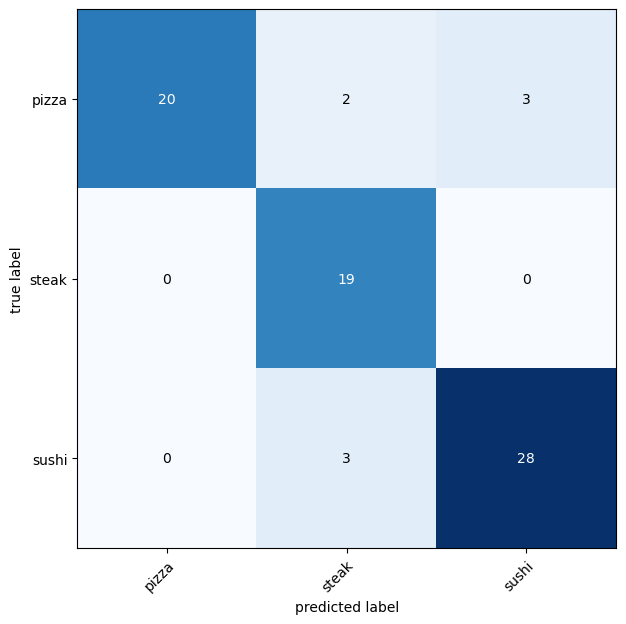

In [77]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)
confmat_values = confmat(preds_tensor[:,0], labels_tensor)

plot_confusion_matrix(conf_mat=confmat_values.cpu().numpy(), class_names=class_names, figsize=(10, 7))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [87]:
import pandas as pd 

frame = pd.DataFrame({"sample:": IMAGE_PATHS, "label:": labels, "prediction:": preds_tensor[:,0].cpu().numpy(), "confidence:":preds_tensor[:,1].cpu().numpy()})
frame

,sample:,label:,prediction:,confidence:
0,data\pizza_steak_sushi\test\pizza\1152100.jpg,0,0.0,0.747919
1,data\pizza_steak_sushi\test\pizza\1503858.jpg,0,0.0,0.603522
2,data\pizza_steak_sushi\test\pizza\1687143.jpg,0,1.0,0.467022
3,data\pizza_steak_sushi\test\pizza\1925494.jpg,0,0.0,0.778165
4,data\pizza_steak_sushi\test\pizza\194643.jpg,0,0.0,0.397510
...,...,...,...,...
70,data\pizza_steak_sushi\test\sushi\684266.jpg,2,1.0,0.534575
71,data\pizza_steak_sushi\test\sushi\719108.jpg,2,2.0,0.533373
72,data\pizza_steak_sushi\test\sushi\858157.jpg,2,2.0,0.508999
73,data\pizza_steak_sushi\test\sushi\887831.jpg,2,2.0,0.441076


In [91]:
filtered_wrong_values = frame[frame['label:'] != frame["prediction:"]]

In [96]:
res = filtered_wrong_values.sort_values(by=["confidence:"], ascending=False)[:5]
res

,sample:,label:,prediction:,confidence:
70,data\pizza_steak_sushi\test\sushi\684266.jpg,2,1.0,0.534575
2,data\pizza_steak_sushi\test\pizza\1687143.jpg,0,1.0,0.467022
13,data\pizza_steak_sushi\test\pizza\2871261.jpg,0,1.0,0.447632
24,data\pizza_steak_sushi\test\pizza\971934.jpg,0,2.0,0.441664
44,data\pizza_steak_sushi\test\sushi\1172255.jpg,2,1.0,0.437054


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [98]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

def pred_and_plot(model: torch.nn.Module, 
                    image_path: str,
                    transform: transforms.Compose,
                    class_names: list[str] = None):
        model = model.to(device)
        # load image
        img = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
        # setup transformed image 
        transformed_img = transform(img).to(device)
        # forward pass 
        logits = model(transformed_img.unsqueeze(dim=0))
        pred = torch.softmax(logits, dim=-1).argmax(dim=-1)
        # plot the image along with the label 
        plt.imshow(transformed_img.permute(1, 2, 0).cpu())
        title = f"{class_names[pred]} | {torch.softmax(logits, dim=-1).max():.3f}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


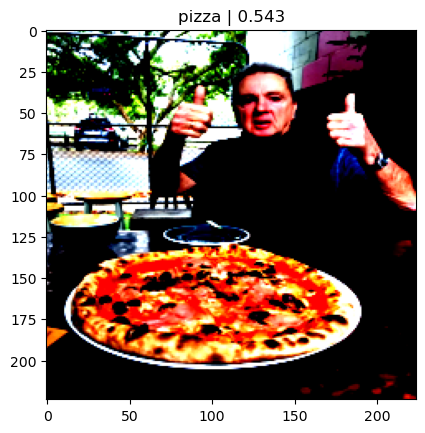

In [100]:
# TODO: Get an image of pizza/steak/sushi
pred_and_plot(model=model_0, image_path="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg", 
                transform=simple_transform, class_names=class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


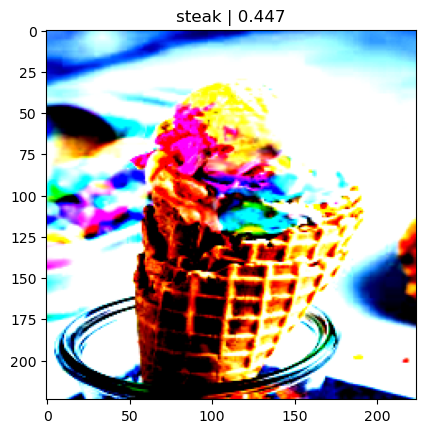

In [102]:
# TODO: Get an image of not pizza/steak/sushi
pred_and_plot(model=model_0, image_path="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-ylLnxUA2MPLbV7caBoSu95iivHOPZtDdRw&s", 
                transform=simple_transform, class_names=class_names)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [110]:
model_0_results = engine.train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

 10%|█         | 1/10 [00:20<03:01, 20.18s/it]

Epoch: 1 | train_loss: 0.6295 | train_acc: 0.7891 | test_loss: 0.6356 | test_acc: 0.8873


100%|██████████| 10/10 [03:28<00:00, 20.89s/it]


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [111]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data\pizza_steak_sushi_20_percent directory exists.


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [112]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [113]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15680819070>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [114]:
# TODO: Recreate a new model 
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
for param in model_1.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

c:\Users\bolth\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bolth\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

### Train a model with 20% of the data

In [117]:
model_1_results = engine.train(model=model_1, train_dataloader=train_dataloader_20_percent, test_dataloader=test_dataloader_20_percent, optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

 10%|█         | 1/10 [01:07<10:08, 67.60s/it]

Epoch: 1 | train_loss: 0.5320 | train_acc: 0.8037 | test_loss: 0.4583 | test_acc: 0.8257


100%|██████████| 10/10 [11:02<00:00, 66.27s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


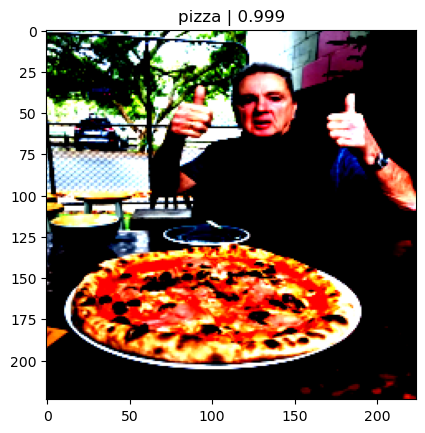

In [118]:
pred_and_plot(model=model_1, image_path="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg", 
                transform=simple_transform, class_names=class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


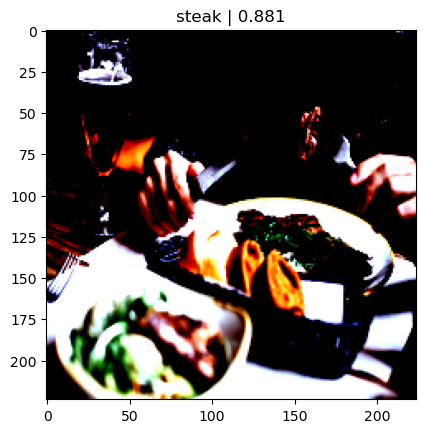

In [121]:
pred_and_plot(model=model_1, image_path="https://plus.unsplash.com/premium_photo-1661333445464-c39e609c7d52?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D", 
                transform=simple_transform, class_names=class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


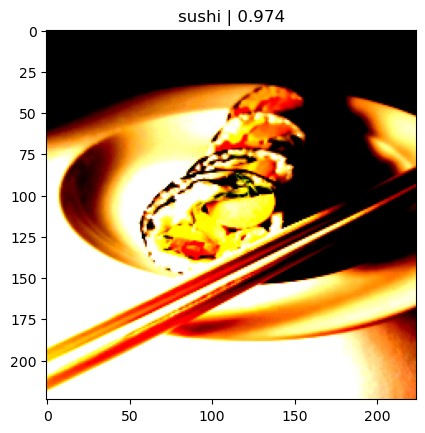

In [127]:
pred_and_plot(model=model_1, image_path="https://images.unsplash.com/photo-1709741123566-4083be97eb35?q=80&w=1935&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D", 
                transform=simple_transform, class_names=class_names)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# TODO 